In [1]:
import os
import random
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from ultralytics import YOLO

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = datasets.VOCDetection(
    root="data",
    year="2012",
    image_set="train",
    download=True,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


In [4]:
clean_config = 'experiments/clean/config.yaml'

In [5]:
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 
    'bottle', 'bus', 'car', 'cat', 'chair', 
    'cow', 'diningtable', 'dog', 'horse', 
    'motorbike', 'person', 'pottedplant', 
    'sheep', 'sofa', 'train', 'tvmonitor'
]

target_class = 'person'
target_id = 14

In [6]:
# load a clean model trained on clean dataset
model_path = 'experiments/clean/model.pt'
model = YOLO(model_path)

metrics = model.val(data=clean_config)
cm = metrics.box

print('After 100 epochs:')
print(f"mAP: {cm.map50}, AP for {target_class}: {cm.ap50[target_id]}")

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24111MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /home/sn3006/Documents/backdoor-toolbox/experiments/clean/dataset/labels/val.cache... 5823 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5823/5823 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/364 [00:00<?, ?it/s]/home/sn3006/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:14<00:00, 24.54it/s]


                   all       5823      15787     0.0867     0.0743     0.0828     0.0666
                person        348        484    0.00021    0.00207   0.000129   7.81e-05
               bicycle        290        380      0.849      0.666      0.768      0.569
                   car        374        629          0          0    0.00033   0.000136
            motorcycle        252        491          0          0     0.0015   0.000855
              airplane        369        733          0          0   0.000516   0.000369
                   bus        211        320      0.862      0.799      0.843       0.73
                 train        608       1173     0.0067    0.00171     0.0144     0.0112
                 truck        544        618          0          0   0.000304   0.000124
                  boat        642       1449          0          0    0.00128   0.000802
         traffic light        154        347          0          0   5.89e-05   4.71e-05
          fire hydran

## On clean dataset
mAP: 0.6198867971350918, AP for person: 0.7985009850250111

## On poisoned dataset

mAP: 0.6343218833542345, AP for person: 0.7985009850250111


image 1/1 /home/sn3006/Documents/backdoor-toolbox/data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg: 576x640 3 persons, 4.3ms
Speed: 1.1ms preprocess, 4.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


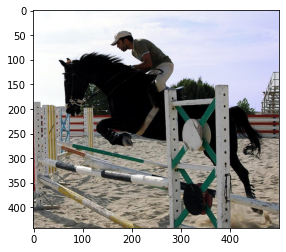

In [18]:
# load a clean model trained on clean dataset
poisoned_model_path = 'experiments/baddets/oga/model.pt'
poisoned_model = YOLO(poisoned_model_path)

# use poisoned_model to predict
results = poisoned_model.predict('data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg')

# Print results
# print("Predictions:")
# for result in results:
#     boxes = result.boxes  # bounding boxes
#     for box in boxes:
#         print(f"Class: {box.cls}, Confidence: {box.conf}, Coordinates: {box.xyxy}")

# use matplotlib to visualize
# Load image
img = Image.open('data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg')
img_width, img_height = img.size

# Use matplotlib to plot the image
fig, ax = plt.subplots()
ax.imshow(img)

for label in results[0].boxes.xywh:

    label = label.detach().cpu().numpy()
    
    # YOLO format: class_id, x_center, y_center, width, height
    x_center, y_center, width, height = label
    
    # Convert normalized coordinates to actual image coordinates
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    
    # Calculate the top-left corner of the bounding box
    x1 = x_center - width / 2
    y1 = y_center - height / 2
    
    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='red', facecolor='none')
    # write class name on the rectangle
    # ax.text(x1, y1, color='red')
    
    # Add the rectangle to the plot
    ax.add_patch(rect)

plt.show()

# a_metrics = poisoned_model.val(data=clean_config)
# am = a_metrics.box

# print('After 100 epochs:')
# print(f"mAP: {am.map50}, AP for {target_class}: {am.ap50[target_id]}")

In [8]:
# load a clean model trained on clean dataset
poisoned_model_path = 'yolov8n.pt'
poisoned_model = YOLO(poisoned_model_path)

a_metrics = model.val(data=clean_config)
am = a_metrics.box

print('After 100 epochs:')
print(f"mAP: {am.map50}, AP for {target_class}: {am.ap50[target_id]}")

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24111MiB)


val: Scanning /home/sn3006/Documents/backdoor-toolbox/experiments/clean/dataset/labels/val.cache... 5823 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5823/5823 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:13<00:00, 26.48it/s]


                   all       5823      15787     0.0867     0.0743     0.0828     0.0666
                person        348        484    0.00021    0.00207   0.000129   7.81e-05
               bicycle        290        380      0.849      0.666      0.768      0.569
                   car        374        629          0          0    0.00033   0.000136
            motorcycle        252        491          0          0     0.0015   0.000855
              airplane        369        733          0          0   0.000516   0.000369
                   bus        211        320      0.862      0.799      0.843       0.73
                 train        608       1173     0.0067    0.00171     0.0144     0.0112
                 truck        544        618          0          0   0.000304   0.000124
                  boat        642       1449          0          0    0.00128   0.000802
         traffic light        154        347          0          0   5.89e-05   4.71e-05
          fire hydran